# Empathy Style Transfer

In [74]:
# IMPORTS
import os
import torch
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast


# CONFIGS
warnings.filterwarnings('ignore')
ORI_PATH = "data/ec_low_mean_emp.csv"
GEN_PATH = "data/ec_low_mean_emp_gen_da.csv"
DIFF_PATH = "data/ec_low_mean_emp_diff_da.csv"
FULL_PATH = "data/ec_low_mean_emp_full_da.csv"

## Calculate difference in empathy scores

In [75]:
# Calculate
def get_diff(path_ori, path_gen, style='empathy'):
    df_ori = pd.read_csv(path_ori)
    df_gen = pd.read_csv(path_gen)
    df = pd.DataFrame()
    df[f"diff_{style}"] = df_gen[style] - df_ori[style]
    return df

df = get_diff(ORI_PATH, GEN_PATH)
df.to_csv(DIFF_PATH, index=False, encoding='utf-8')

In [ ]:
# Report difference in empathy scores & accuracy
stat_change_report(df, 'diff_empathy', True)

## Concat all 3 (original data, generated data, difference data)

In [76]:
pd.concat([
    pd.read_csv(ORI_PATH, encoding='utf-8'),
    pd.read_csv(GEN_PATH, encoding='utf-8').drop(['conv_id','turn_id','speaker'],axis=1).rename(columns=lambda x: 'gen_'+x),
    pd.read_csv(DIFF_PATH,encoding='utf-8')
], axis=1).to_csv(FULL_PATH,encoding='utf-8',index=False)

## Calculate sentence length

In [77]:
df = pd.read_csv(FULL_PATH)
df['wc'] = df['utterance'].str.count(' ')+1
df['gen_wc'] = df['gen_utterance'].str.count(' ')+1
df.to_csv(FULL_PATH, encoding="utf-8", index=False)

## Calculate perplexity

In [68]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("gpt2-large").to(DEVICE)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2-large")
model.eval();

In [78]:
def get_ppl(row, tokenizer, model):
    encodings = tokenizer(row["gen_utterance"], return_tensors="pt")
    input_ids = encodings['input_ids'].to(DEVICE)
    target_ids = input_ids.clone()
    loss = 0.0
    with torch.no_grad():
        loss = model(input_ids, labels=target_ids).loss.cpu()
    return torch.exp(loss).item()

df = pd.read_csv(FULL_PATH)
df['ppl'] = df.apply(lambda row: get_ppl(row, tokenizer, model), axis=1)
df.to_csv(FULL_PATH, encoding="utf-8", index=False)

## Get dialog act category

In [ ]:
sd_set = {'sd'}                                                 # facts
sv_set = {'sv'}                                                 # opinions
q_set = {'qy','qw','qo','qr','^d','^g'}                         # questions
f_set = {'fp','fc','fx','fe','fo','ft','fw','fa','qh'}          # forward communications
a_set = {'aa','am','ar','^h'}                                   # agreements
b_set = {'br','b','bh','bk','bf','ba','by','bd','bc','^m','^2'} # backward communications
n_set = {'ny','nn','na','ng','no','^e','nd'}                    # yes/no answers
o_set = {'^q','h','+','%','t1','t3'}                            # others

def type_count(row, gen=False):
    id = 'gen_da' if gen else 'da'
    if row[id] == 'sd':
        return 'fact'
    if row[id] == 'sv':
        return 'opinion'
    if row[id] in q_set:
        return 'question'
    if row[id] in f_set:
        return 'forward'
    if row[id] in a_set:
        return 'agreement'
    if row[id] in b_set:
        return 'backward'
    if row[id] in n_set:
        return 'answer'
    return 'others'

df = pd.read_csv(FULL_PATH)
df['da_category'] = df.apply(lambda row: type_count(row), axis=1)
df['gen_da_category'] = df.apply(lambda row: type_count(row, True), axis=1)
df.to_csv(FULL_PATH, encoding="utf-8", index=False)

## Calculate dialog act preservation accuracy

In [ ]:
print(f"DA_pres_rate: {sum(1 for i in range(len(df)) if df.loc[i,'da'] in eval(df.loc[i,'gen_dialog_act']))/len(df)}\n")

## Calculate BLEURT

In [ ]:
# prepare files for BLEURT and BERTScore calculations
dir_path = "bleurt/bleurt/test_data"
identifier = "_da_exp"
ref_name = "references_emp"
can_name = f"candidates_emp{identifier}"
FULL_PATH = f"data/ec_low_mean_emp_full{identifier}.csv"    
df = pd.read_csv(FULL_PATH)

with open(os.path.join(dir_path, ref_name), 'w') as f:
    for line in df['utterance'].tolist():
        f.write(line+'\n')
        
with open(os.path.join(dir_path, can_name), 'w') as f:
    for line in df['gen_utterance'].tolist():
        f.write(' '.join(line.split())+'\n')

In [ ]:
# install BLEURT modules
%%capture
!pip install --upgrade pip
!git clone https://github.com/google-research/bleurt.git

In [ ]:
# install BLEURT-20
%%capture
%cd bleurt/
!pip install .
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip .
!unzip BLEURT-20.zip

In [ ]:
# run scoring
!python -m bleurt.score_files -candidate_file=../candidates_emp_da_exp -reference_file=../references_emp -bleurt_checkpoint=BLEURT-20 -scores_file=../scores_emp

In [1]:
# get mean BLEURT score across all 1016 samples
scores = 0
with open("../scores_emp", 'r') as f:
    for line in f:
        scores += eval(line)
print(scores / 1016)

## Calculate BERTScore

In [ ]:
# install BERTScore
%%capture
!pip install torch --upgrade
!pip install transformers --upgrade
!pip install bert_score --upgrade

In [ ]:
from bert_score import score

# read sentences from file
with open("candidates_emp",'r') as f:
    cands = [line.strip() for line in f]

with open("references_emp",'r') as f:
    refs = [line.strip() for line in f]
    
# calculate P,R,F1 (first time downloading takes long because of model size.)
P, R, F1 = score(cands, refs, lang="en", verbose=True, model_type="microsoft/deberta-xlarge-mnli")

# report mean F1
print(f"System level F1 score: {F1.mean():.3f}")

## DA-Specific Analysis

### Plot mean empathy boost, style transfer accuracy, and mean BLEURT scores

In [ ]:
method_list = ['zero','pair','target','da-pair (imp)','da-target (imp)','da-pair (exp)','da-target (exp)']
method_dict = {
    'zero':'_zero',
    'pair':'_pair',
    'target':'',
    'da-pair (imp)':'_pair_da',
    'da-target (imp)':'_da',
    'da-pair (exp)':'_pair_da_exp',
    'da-target (exp)':'_da_exp',
}

da_list = ['fact', 'opinion', 'question', 'forward', 'agreement', 'answer', 'backward']
da_dict = {
    'fact': sd_set,
    'opinion': sv_set,
    'question': q_set,
    'forward': f_set,
    'agreement': a_set,
    'answer': n_set,
    'backward': b_set,
}

def get_data(method, da, column):
    df = pd.read_csv(f"data/ec_low_mean_emp_full{method_dict[method]}.csv")
    return df[df['da'].isin(da_dict[da])][column].mean()

def get_acc(method, da):
    df = pd.read_csv(f"data/ec_low_mean_emp_full{method_dict[method]}.csv")
    df = df[df['da'].isin(da_dict[da])]
    return len(df[df['diff_empathy'] > 0]) / len(df)

df_emp = pd.melt(pd.DataFrame({method: {da: get_data(method, da, "diff_empathy") for da in da_list} for method in method_list}).reset_index(), id_vars=['index'])
df_emp.columns = ['input dialog act', 'method', 'mean empathy boost']

df_acc = pd.melt(pd.DataFrame({method: {da: get_acc(method, da) for da in da_list} for method in method_list}).reset_index(), id_vars=['index'])
df_acc.columns = ['input dialog act', 'method', 'style transfer accuracy']

df_sim = pd.melt(pd.DataFrame({method: {da: get_data(method, da, "text_similarity") for da in da_list} for method in method_list}).reset_index(), id_vars=['index'])
df_sim['value'] = df_sim['value'] - 0.25
df_sim.columns = ['input dialog act', 'method', 'mean bleurt score']

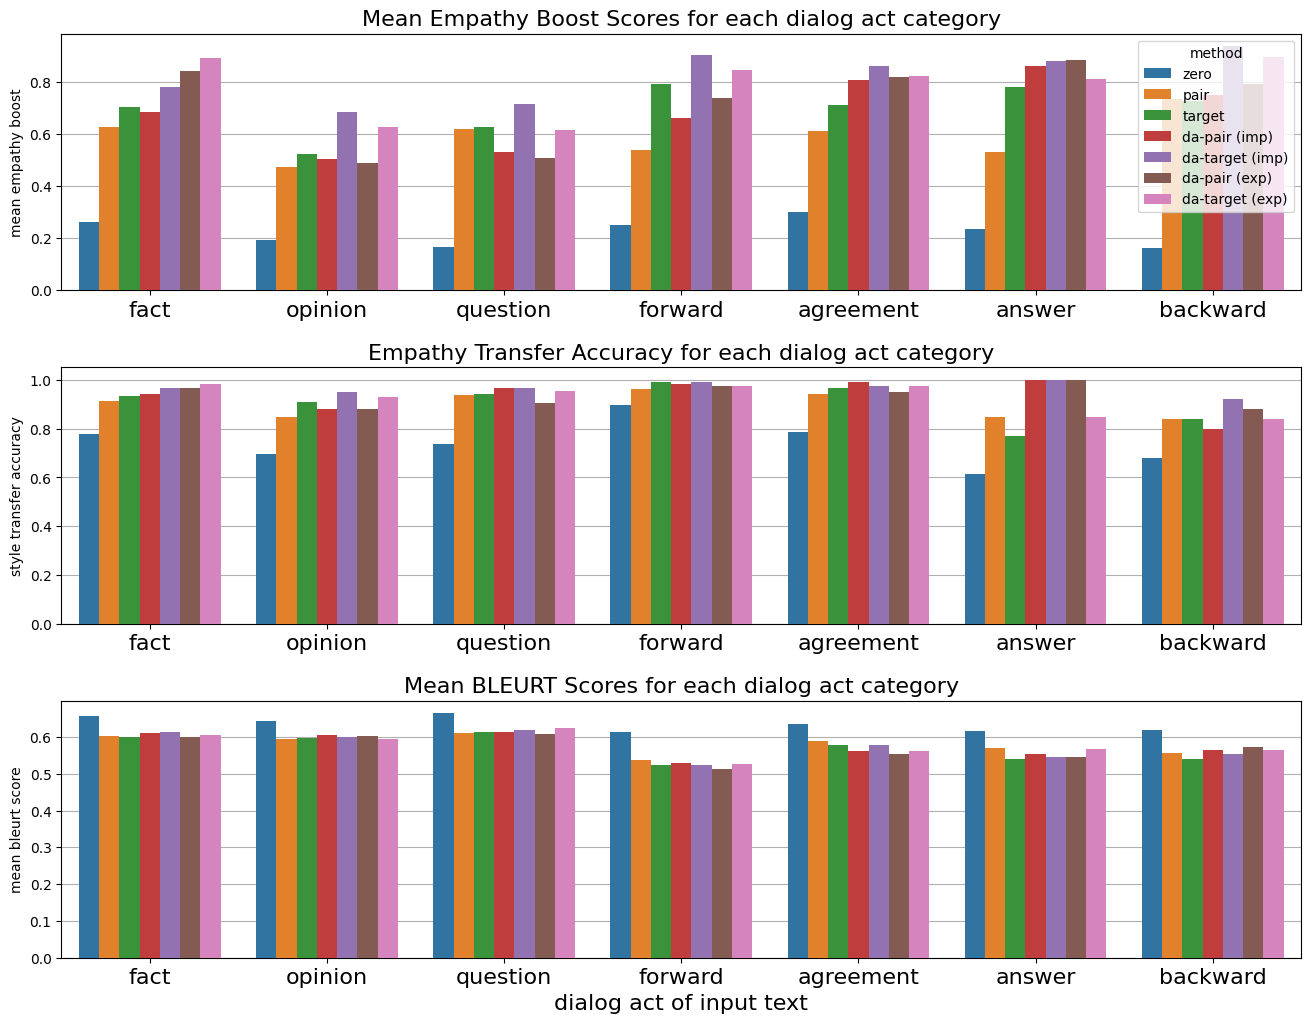

In [ ]:
plt.rcParams["figure.figsize"] = (16,12)
fig, axes = plt.subplots(3,1)
plt.subplots_adjust(hspace=0.3)
fs = 16

sns.barplot(data=df_emp, x='input dialog act', y='mean empathy boost', hue='method', ax=axes[0], zorder=3)
axes[0].set_title("Mean Empathy Boost Scores for each dialog act category", fontsize=fs)
axes[0].set_xlabel("")
axes[0].xaxis.set_tick_params(labelsize=fs)
axes[0].grid(axis='y', zorder=0)

sns.barplot(data=df_acc, x='input dialog act', y='style transfer accuracy', hue='method', ax=axes[1], zorder=3)
axes[1].set_title("Empathy Transfer Accuracy for each dialog act category", fontsize=fs)
axes[1].set_xlabel("")
axes[1].xaxis.set_tick_params(labelsize=fs)
axes[1].grid(axis='y', zorder=0)
axes[1].get_legend().remove()

sns.barplot(data=df_sim, x='input dialog act', y='mean bleurt score', hue='method', ax=axes[2], zorder=3)
axes[2].set_title("Mean BLEURT Scores for each dialog act category", fontsize=fs)
axes[2].set_xlabel("dialog act of input text", fontsize=fs)
axes[2].xaxis.set_tick_params(labelsize=fs)
axes[2].grid(axis='y', zorder=0)
axes[2].get_legend().remove()

# plt.xticks(fontsize=fs)
plt.show()

### Plot changes in the source dialog act categories after style transfer

In [ ]:
def get_da_counts(type, path):
    df = pd.read_csv(path)
    return df[df['da_category']==type]['gen_da_category']

def get_da_df(cat):
    df = pd.concat([
        get_da_counts(cat, "results/ec_low_mean_emp_full_zero.csv"), 
        get_da_counts(cat, "results/ec_low_mean_emp_full_pair.csv"), 
        get_da_counts(cat, "results/ec_low_mean_emp_full.csv"), 
        get_da_counts(cat, "results/ec_low_mean_emp_full_dapair.csv"), 
        get_da_counts(cat, "results/ec_low_mean_emp_full_da.csv"), 
        get_da_counts(cat, "results/ec_low_mean_emp_full_daexppair.csv"), 
        get_da_counts(cat, "results/ec_low_mean_emp_full_daexp.csv"), 
    ], axis=1).reset_index(drop=True)
    df.columns = ['zero','pair','target','da_pair','da_target','da_e_pair','da_e_target']
    return df

df_fact = get_da_df('fact')
df_opinion = get_da_df('opinion')
df_question = get_da_df('question')
df_forward = get_da_df('forward')
df_agreement = get_da_df('agreement')
df_backward = get_da_df('backward')
df_answer = get_da_df('answer')
df_others = get_da_df('others')

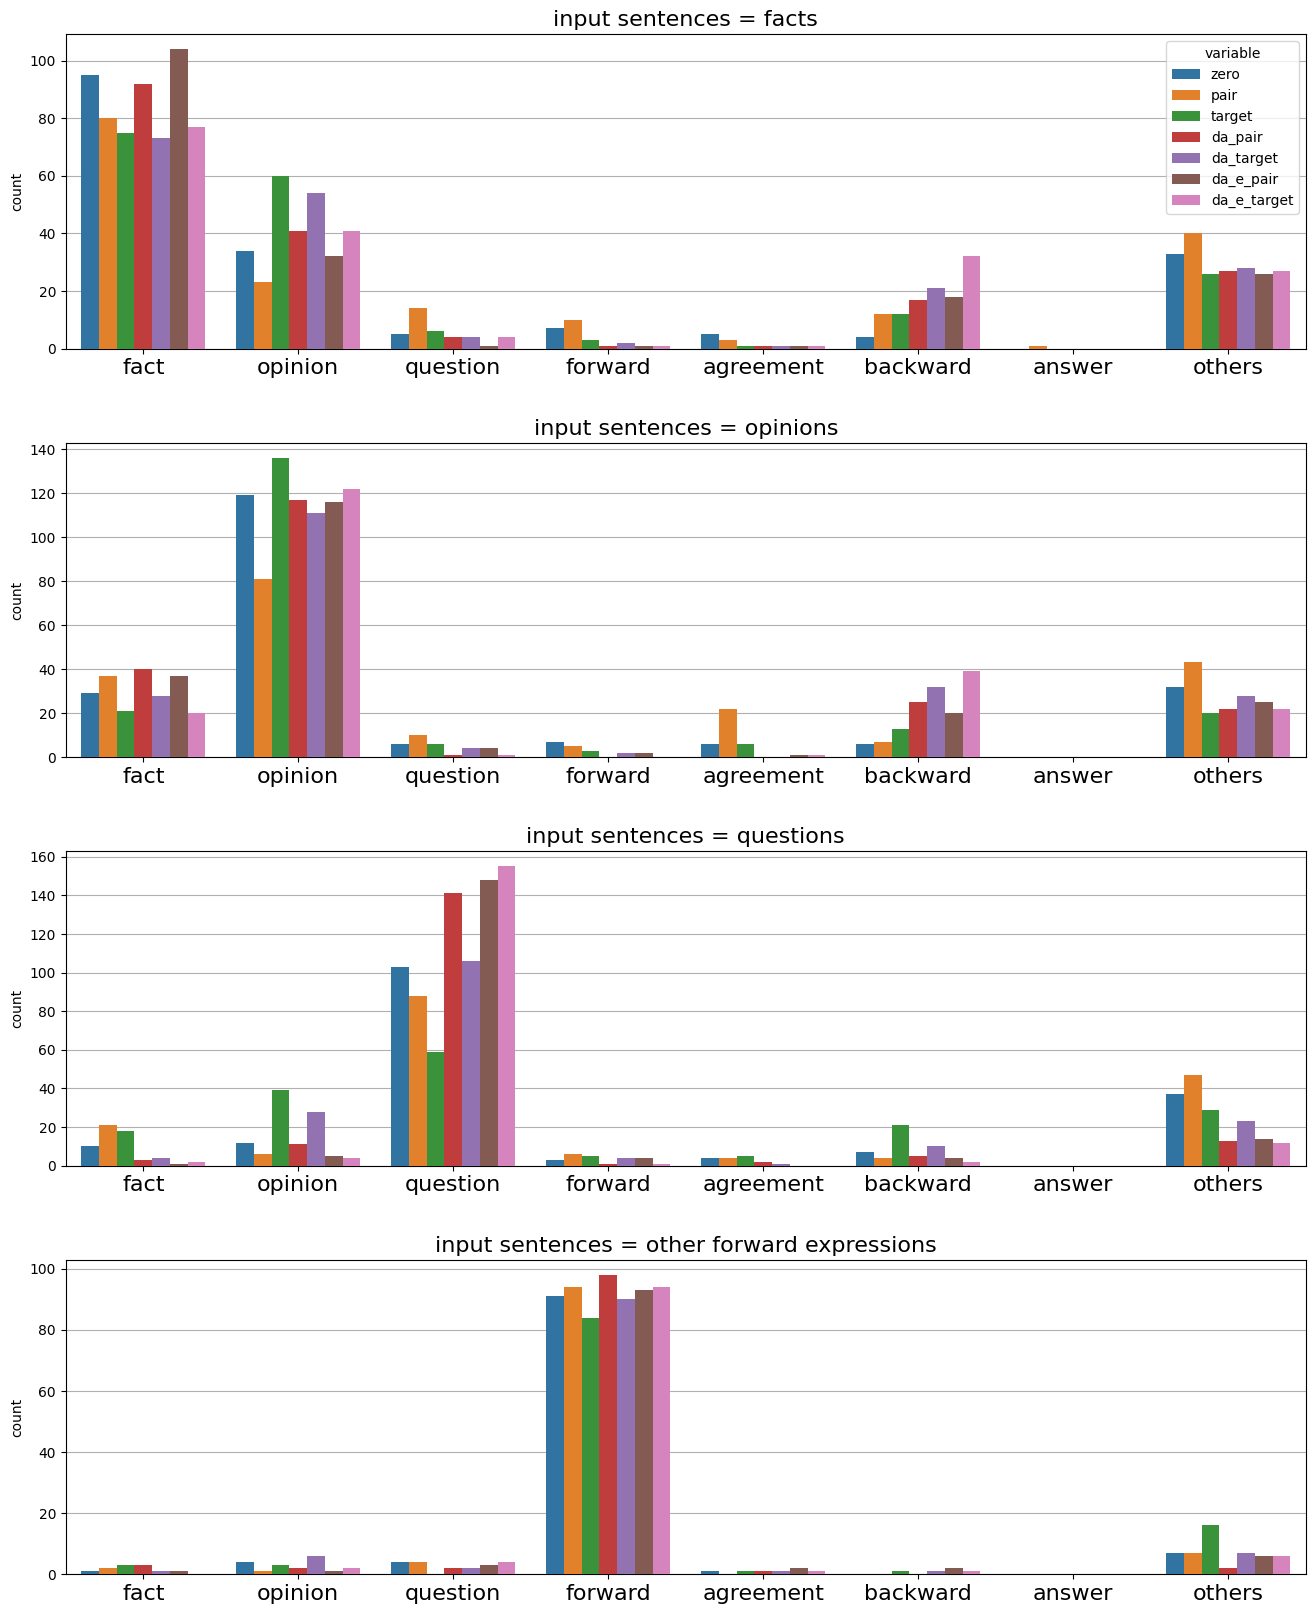

In [ ]:
# forward communications
plt.rcParams["figure.figsize"] = (16,20)
fig, axes = plt.subplots(4,1)
plt.subplots_adjust(hspace=0.3)
fs = 16

sns.countplot(data=pd.melt(df_fact), x='value', hue='variable', ax=axes[0], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[0].set_title("input sentences = facts", fontsize=fs)
axes[0].set_xlabel("")
axes[0].xaxis.set_tick_params(labelsize=fs)
axes[0].grid(axis='y', zorder=0)

sns.countplot(data=pd.melt(df_opinion), x='value', hue='variable', ax=axes[1], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[1].set_title("input sentences = opinions", fontsize=fs)
axes[1].set_xlabel("")
axes[1].xaxis.set_tick_params(labelsize=fs)
axes[1].grid(axis='y', zorder=0)
axes[1].get_legend().remove()

sns.countplot(data=pd.melt(df_question), x='value', hue='variable', ax=axes[2], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[2].set_title("input sentences = questions", fontsize=fs)
axes[2].set_xlabel("")
axes[2].xaxis.set_tick_params(labelsize=fs)
axes[2].grid(axis='y', zorder=0)
axes[2].get_legend().remove()

sns.countplot(data=pd.melt(df_forward), x='value', hue='variable', ax=axes[3], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[3].set_title("input sentences = other forward expressions", fontsize=fs)
axes[3].set_xlabel("")
axes[3].xaxis.set_tick_params(labelsize=fs)
axes[3].grid(axis='y', zorder=0)
axes[3].get_legend().remove()

plt.show()

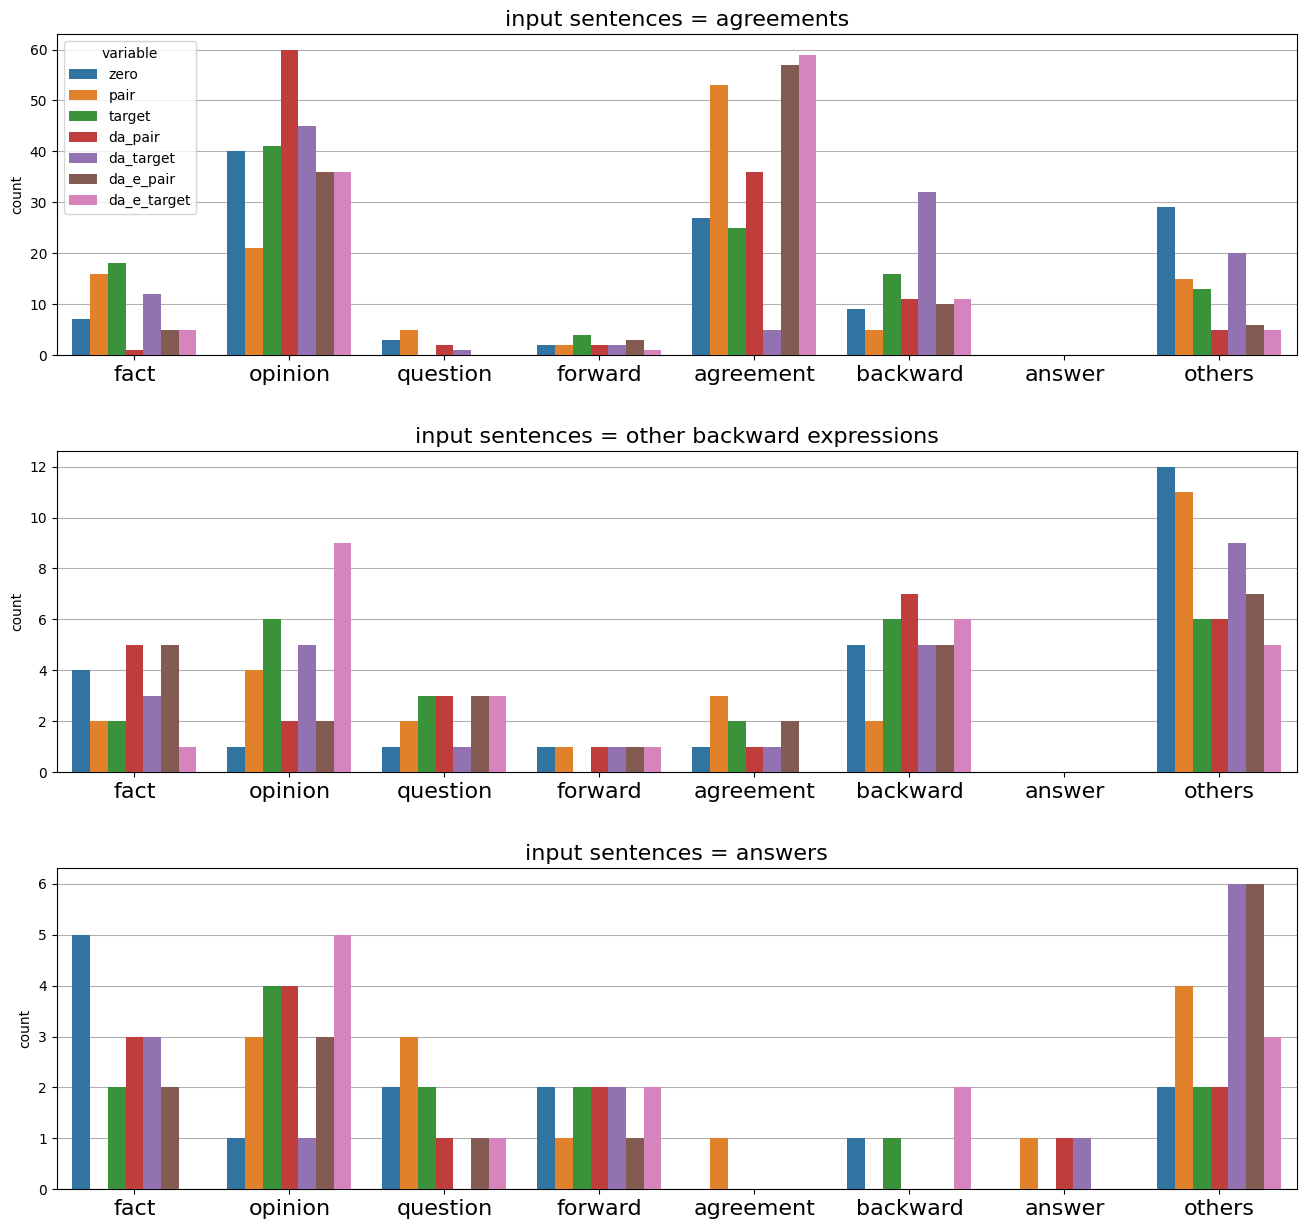

In [ ]:
# backward communications
plt.rcParams["figure.figsize"] = (16,15)
fig, axes = plt.subplots(3,1)
plt.subplots_adjust(hspace=0.3)
fs = 16

sns.countplot(data=pd.melt(df_agreement), x='value', hue='variable', ax=axes[0], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[0].set_title("input sentences = agreements", fontsize=fs)
axes[0].set_xlabel("")
axes[0].xaxis.set_tick_params(labelsize=fs)
axes[0].grid(axis='y', zorder=0)

sns.countplot(data=pd.melt(df_backward), x='value', hue='variable', ax=axes[1], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[1].set_title("input sentences = other backward expressions", fontsize=fs)
axes[1].set_xlabel("")
axes[1].xaxis.set_tick_params(labelsize=fs)
axes[1].grid(axis='y', zorder=0)
axes[1].get_legend().remove()

sns.countplot(data=pd.melt(df_answer), x='value', hue='variable', ax=axes[2], order=['fact','opinion','question','forward','agreement','backward','answer','others'], zorder=3)
axes[2].set_title("input sentences = answers", fontsize=fs)
axes[2].set_xlabel("")
axes[2].xaxis.set_tick_params(labelsize=fs)
axes[2].grid(axis='y', zorder=0)
axes[2].get_legend().remove()

# plt.xticks(fontsize=fs)
plt.show()